#### Scripts to generate proteomic analyses for Olink Gdańsk data

###### Loading necessary libraries

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from IPython.display import display

###### Loading raw data

In [107]:
olink_data = pd.read_csv('/mnt/dysk_D/Olink_Gdansk/Result-X204SC25109867-Z01-F002-B1-43/1.Quant/pre_quant.csv', sep='\t')

olink_data.shape # (rows, columns)

olink_data.head() #` First 5 rows of the dataframe`

,SampleID,SampleType,WellID,PlateID,DataAnalysisRefID,OlinkID,UniProt,Assay,AssayType,Panel,...,InterCV,SampleBlockQCWarn,SampleBlockQCFail,BlockQCFail,AssayQCWarn,Group_Name1,Group_Name2,Group_Name3,Group_Name4,Group_Name5
0,P7W1,SAMPLE,A1,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,be_treatment,be_treatment,be_treatment,be_treatment,be_treatment
1,K14,SAMPLE,A2,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
2,K16,SAMPLE,A3,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
3,K18,SAMPLE,A4,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
4,P8W2,SAMPLE,A5,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,treatment_1,treatment_1,treatment_1,NaN,NaN


###### Let's check uniqueness of some columns

In [108]:
single_unique_cols = [col for col in olink_data.columns if olink_data[col].nunique() == 1]
print(f"Columns with a single unique value: {single_unique_cols}")

Columns with a single unique value: ['PlateID', 'DataAnalysisRefID', 'AssayType', 'Panel', 'Block', 'Normalization', 'SampleQC', 'SoftwareVersion', 'SoftwareName', 'PanelDataArchiveVersion', 'PreProcessingVersion', 'PreProcessingSoftware', 'InstrumentType', 'SampleBlockQCFail', 'BlockQCFail']


In [109]:
few_unique_cols = [col for col in olink_data.columns if (olink_data[col].nunique() < 5 and olink_data[col].nunique() > 1)]
print(f"Columns with fewer than 5 unique values but more than 1: {few_unique_cols}")

Columns with fewer than 5 unique values but more than 1: ['SampleType', 'AssayQC', 'SampleBlockQCWarn', 'AssayQCWarn']


In [110]:
na_cols = olink_data.columns[olink_data.isna().any()].tolist()
print(f"Columns with missing values: {na_cols}")

Columns with missing values: ['InterCV', 'Group_Name2', 'Group_Name3', 'Group_Name4', 'Group_Name5']


###### Most of columns with one unique value are trash so we will discard them, we will also delete rows where there are missing values:

In [111]:
cols_to_drop = list(set(single_unique_cols + na_cols))
print(f"Dropping columns: {cols_to_drop}")

olink_data_cleaned = olink_data.drop(columns=cols_to_drop)

Dropping columns: ['PanelDataArchiveVersion', 'SoftwareName', 'SoftwareVersion', 'SampleQC', 'Group_Name3', 'AssayType', 'Block', 'Group_Name5', 'InstrumentType', 'DataAnalysisRefID', 'PreProcessingVersion', 'Panel', 'SampleBlockQCFail', 'Normalization', 'PlateID', 'BlockQCFail', 'InterCV', 'PreProcessingSoftware', 'Group_Name4', 'Group_Name2']


###### Let's see what we have left:

In [45]:
olink_data_cleaned.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,AssayQC,IntraCV,SampleBlockQCWarn,AssayQCWarn,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,PASS,3.440963,1,1,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,PASS,3.440963,1,1,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,PASS,3.440963,1,1,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,PASS,3.440963,1,1,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,PASS,3.440963,1,1,treatment_1


###### We will additionaly drop last four columns and select only that rows which pass the AssayQC criterion:

In [112]:
olink_pass = olink_data_cleaned.iloc[:, list(range(olink_data_cleaned.shape[1]-4)) + [-1]] \
    [olink_data_cleaned['AssayQC'] == 'PASS'] \
    .drop(columns=['AssayQC'], errors='ignore')

olink_pass.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,treatment_1


###### We should see if the distribution of NPX values resembles gaussian curve:

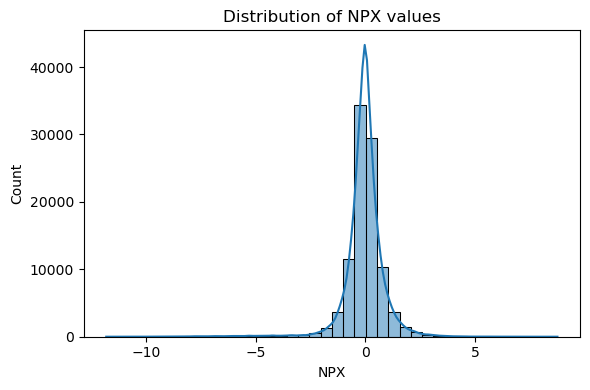

In [47]:
plt.figure(figsize=(6,4))
sns.histplot(olink_pass['NPX'], bins=40, kde=True)
plt.xlabel("NPX")
plt.ylabel("Count")
plt.title("Distribution of NPX values")
plt.tight_layout()
plt.show()

###### This boxplot show which samples are potentially outliers or if there is some batch effect (only if few of samples are not in norm)

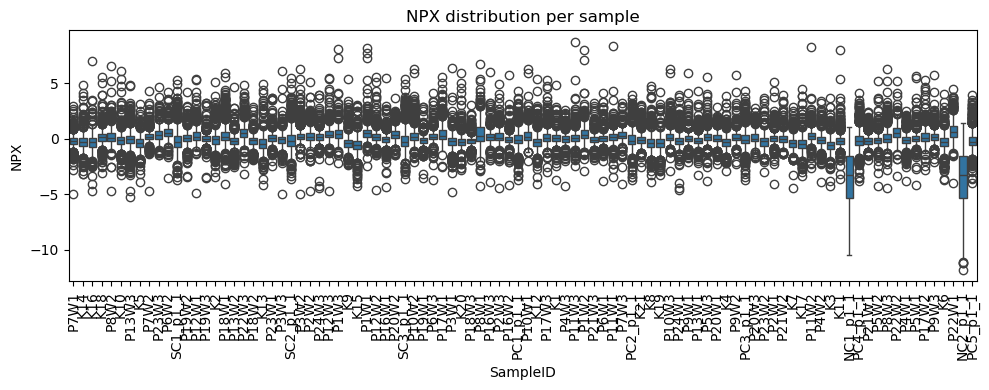

In [48]:
plt.figure(figsize=(10,4))
sns.boxplot(x='SampleID', y='NPX', data=olink_pass)
plt.xticks(rotation=90)
plt.title("NPX distribution per sample")
plt.tight_layout()
plt.show()

###### Every sample seem fine, NC1 and NC2 are negative controls so we predict their values to be lower, now let's see if normalization works:

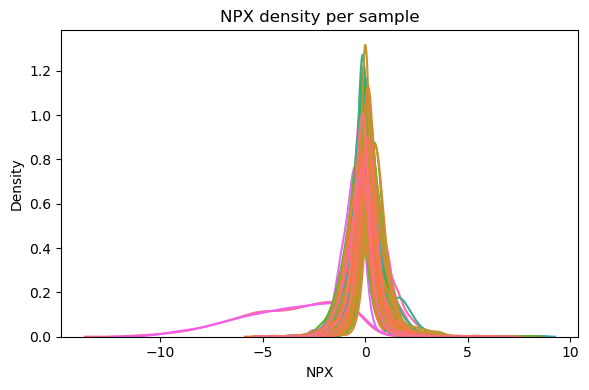

In [49]:
plt.figure(figsize=(6,4))
sns.kdeplot(
    data=olink_pass,
    x='NPX',
    hue='SampleID',
    common_norm=False,
    legend=False
)
plt.title("NPX density per sample")
plt.tight_layout()
plt.show()

In [50]:
olink_pass.groupby('SampleID')['NPX'].agg(['mean', 'std'])

,mean,std
SampleID,,
K1,0.096712,0.586367
K10,-0.101656,0.719089
K11,-0.146184,0.667938
K12,-0.323742,0.728006
K13,-0.451893,0.775077
...,...,...
PC4_p1_1,-0.122187,0.845059
PC5_p1_1,-0.193672,0.846628
SC1_p1_1,-0.171336,1.015400


###### Again, apart from negative control every density line covers so it's OK. Now for PCA and differential expression let's remove this controls from dataset:

In [113]:
olink_pass = olink_pass[~olink_pass['SampleType'].str.contains('CONTROL', na=False)]

olink_pass['SampleID'].unique().tolist()

['P7W1',
 'K14',
 'K16',
 'K18',
 'P8W2',
 'K10',
 'P13W3',
 'K5',
 'P7W2',
 'P23W3',
 'P6W2',
 'P19W2',
 'P12W1',
 'P19W3',
 'K2',
 'P18W1',
 'P13W2',
 'P22W3',
 'P18W2',
 'K13',
 'P23W1',
 'P3W3',
 'P3W2',
 'P2W2',
 'P24W3',
 'P12W3',
 'P1W3',
 'K9',
 'K15',
 'P1W1',
 'P12W2',
 'P16W1',
 'P20W2',
 'P10W2',
 'P19W1',
 'P6W3',
 'P17W1',
 'P3W1',
 'K20',
 'P18W3',
 'P8W1',
 'P16W3',
 'P2W3',
 'P16W2',
 'P10W1',
 'K12',
 'P17W3',
 'K1',
 'P4W3',
 'P11W3',
 'P1W2',
 'P21W3',
 'P6W1',
 'P11W1',
 'P7W3',
 'K21',
 'K8',
 'K19',
 'P10W3',
 'P24W1',
 'P9W1',
 'P13W1',
 'P5W3',
 'P20W1',
 'K4',
 'P9W2',
 'P20W3',
 'P23W2',
 'P2W1',
 'P21W2',
 'K7',
 'K17',
 'P11W2',
 'P4W2',
 'K3',
 'K11',
 'P21W1',
 'P5W2',
 'P8W3',
 'P22W2',
 'P4W1',
 'P5W1',
 'P17W2',
 'P9W3',
 'K6',
 'P22W1']

###### Pivot the table so we will generate PCA and heatmaps easier (protein x samples):

In [52]:
expr_mat = olink_pass.pivot_table(
    index='Assay',
    columns='SampleID',
    values='NPX'
)

###### Before the PCA, we must calculate z-score of protein expression, this will show us "which protein has the highest signal":

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expr_z = pd.DataFrame(
    scaler.fit_transform(expr_mat.T).T,
    index=expr_mat.index,
    columns=expr_mat.columns
)

###### Finally we can do PCA:

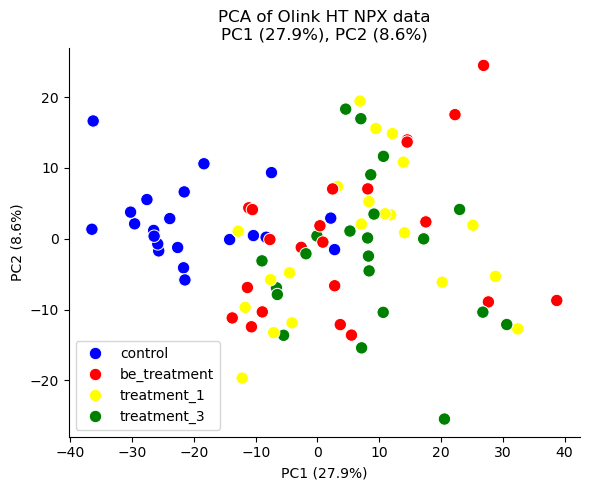

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(expr_z.T)


pca_df = pd.DataFrame(
    pcs,
    columns=['PC1', 'PC2'],
    index=expr_z.columns
)

meta_df = (
    olink_pass[['SampleID', 'Group_Name1']]
    .drop_duplicates()
    .set_index('SampleID')
)



pca_df = pca_df.join(meta_df)


palette = {
    'control': 'blue',
    'be_treatment': 'red',
    'treatment_1': 'yellow',
    'treatment_3': 'green'
}


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Group_Name1',
    palette=palette,
    s=80,       
    alpha=1     
)
plt.title(
    f"PCA of Olink HT NPX data\nPC1 ({pca.explained_variance_ratio_[0]*100:.1f}%), "
    f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='')  
sns.despine()
plt.tight_layout()
plt.show()

###### We will take a closer look at the extremes of two main principal components:

In [64]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
14,K3,-36.516542,1.341041,control
6,K15,-36.309736,16.636219,control
8,K17,-30.252134,3.758816,control
4,K13,-29.598095,2.110817,control
10,K19,-27.609622,5.538398,control


In [66]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
45,P1W1,27.661474,-8.921014,be_treatment
75,P6W2,28.807271,-5.319490,treatment_1
56,P22W3,30.628121,-12.117089,treatment_3
55,P22W2,32.412615,-12.733345,treatment_1
54,P22W1,38.727965,-8.720123,be_treatment


In [65]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
59,P23W3,20.547248,-25.469624,treatment_3
58,P23W2,-12.194732,-19.683170,treatment_1
50,P20W3,7.141182,-15.413032,treatment_3
67,P3W3,-5.486066,-13.639552,treatment_3
57,P23W1,5.500286,-13.611975,be_treatment


In [67]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
82,P8W3,7.016024,16.958689,treatment_3
36,P17W1,22.255168,17.533137,be_treatment
38,P17W3,4.563778,18.311756,treatment_3
37,P17W2,6.879549,19.442753,treatment_1
80,P8W1,26.884143,24.487169,be_treatment


###### As we can observe there is no sample with outstanding high or low variation, we will not exclude any sample. Now let's move to differential analysis

In [114]:
group_map = {
    'control': 'Control',
    'be_treatment': 'Treatment',
    'treatment_1': 'Treatment',
    'treatment_3': 'Treatment'
}

olink_pass['Group_simple'] = olink_pass['Group_Name1'].map(group_map)
#olink_pass['Group_simple'].value_counts()

olink_long = (
    olink_pass[['Assay', 'SampleID', 'NPX', 'Group_simple']].dropna(subset=['Group_simple']) 
)

###### Now that we have two groups (control vs treatment) we cab actually make diff analysis:

In [75]:
results = []

for assay, df_a in olink_long.groupby('Assay'):
    ctrl = df_a.loc[df_a['Group_simple'] == 'Control', 'NPX']
    trt  = df_a.loc[df_a['Group_simple'] == 'Treatment', 'NPX']

    if len(ctrl) < 2 or len(trt) < 2:
        continue

    t_stat, p_val = ttest_ind(trt, ctrl, nan_policy='omit')

    results.append({
        'Assay': assay,
        'mean_Treatment': trt.mean(),
        'mean_Control': ctrl.mean(),
        'lfc': trt.mean() - ctrl.mean(),
        't_stat': t_stat,
        'p_value': p_val
    })

diff_results = pd.DataFrame(results)

diff_results['fdr'] = multipletests(
    diff_results['p_value'],
    method='fdr_bh'
)[1]

diff_results = diff_results.sort_values('fdr')

diff_results.head()

,Assay,mean_Treatment,mean_Control,lfc,t_stat,p_value,fdr
314,EDA2R,0.255216,-1.363359,1.618575,12.182957,2.944262e-20,3.038479e-17
301,DPY30,0.141529,-0.868658,1.010187,11.999968,6.636256e-20,3.424308e-17
459,IFI30,0.192247,-1.488408,1.680655,11.038136,5.016513e-18,1.725680e-15
452,HSPB6,0.161784,-0.829121,0.990905,10.459065,7.042832e-17,1.817051e-14
554,KLRF1,0.127361,-0.810486,0.937848,10.352553,1.147872e-16,2.369209e-14


###### Let's visualize diff_result matrix by volcano plot:

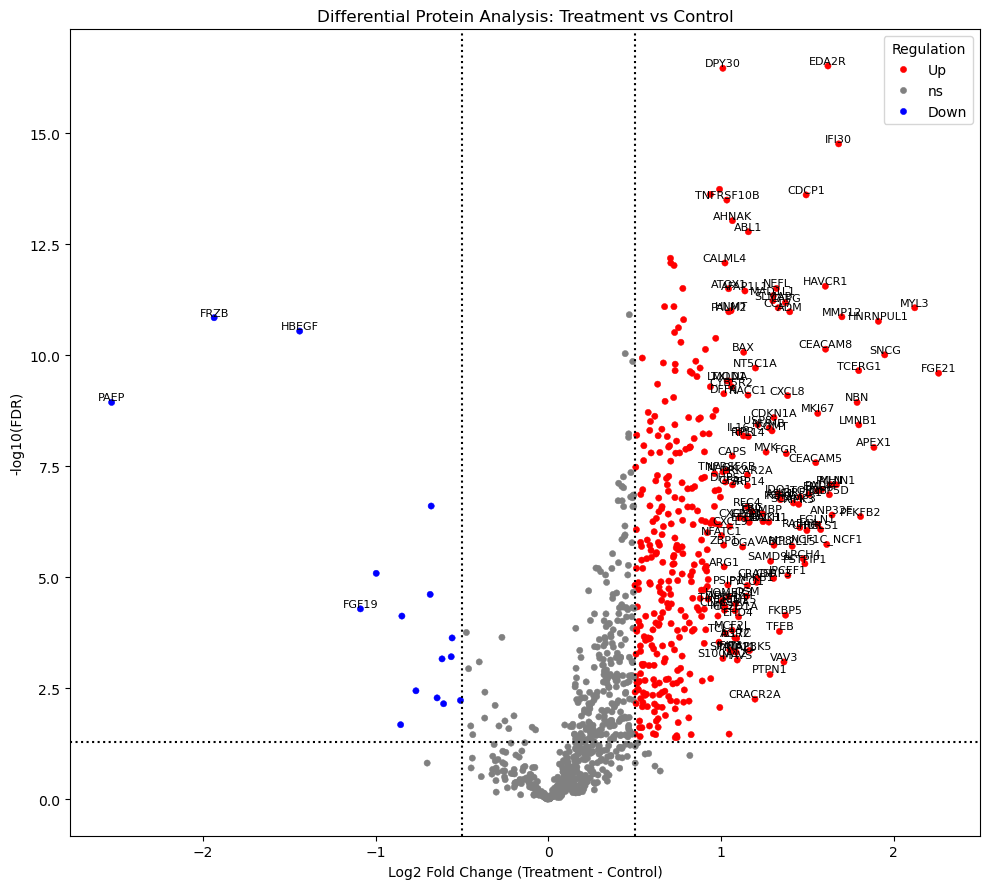

In [79]:
diff_results['neglog10_fdr'] = -np.log10(diff_results['fdr'])

diff_results['Regulation'] = np.where(
    (diff_results['fdr'] >= 0.05) | (diff_results['lfc'].abs() <= 0.5),
    'ns',
    np.where(diff_results['lfc'] > 0.5, 'Up', 'Down')
)

palette = {
    'Up': 'red',
    'Down': 'blue',
    'ns': 'grey'
}


plt.figure(figsize=(10,9))

sns.scatterplot(
    data=diff_results,
    x='lfc',
    y='neglog10_fdr',
    hue='Regulation',
    palette=palette,
    s=20,
    edgecolor=None
)


plt.axhline(-np.log10(0.05), linestyle='dotted', color='black')
plt.axvline(0.5, linestyle='dotted', color='black')
plt.axvline(-0.5, linestyle='dotted', color='black')

label_df = diff_results.query("fdr < 0.01 and abs(lfc) > 1")

for _, row in label_df.iterrows():
    plt.text(
        row['lfc'],
        row['neglog10_fdr'],
        row['Assay'],
        fontsize=8,
        ha='center',
        va='bottom'
    )


plt.title("Differential Protein Analysis: Treatment vs Control")
plt.xlabel("Log2 Fold Change (Treatment - Control)")
plt.ylabel("-log10(FDR)")
plt.legend(title="Regulation")
plt.tight_layout()
plt.show()

###### Summary with table for fdr < 0.05

In [80]:
reg_summary_fdr = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < 0), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr

,Regulation,n_genes
0,Down,31
1,Up,638


###### and with |lfc| > 0.5

In [81]:
reg_summary_fdr_lfc = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0.5), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < -0.5), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr_lfc

,Regulation,n_genes
0,Down,16
1,Up,408


###### Lastly we will add heatmap with clustered samples and top most variable proteins

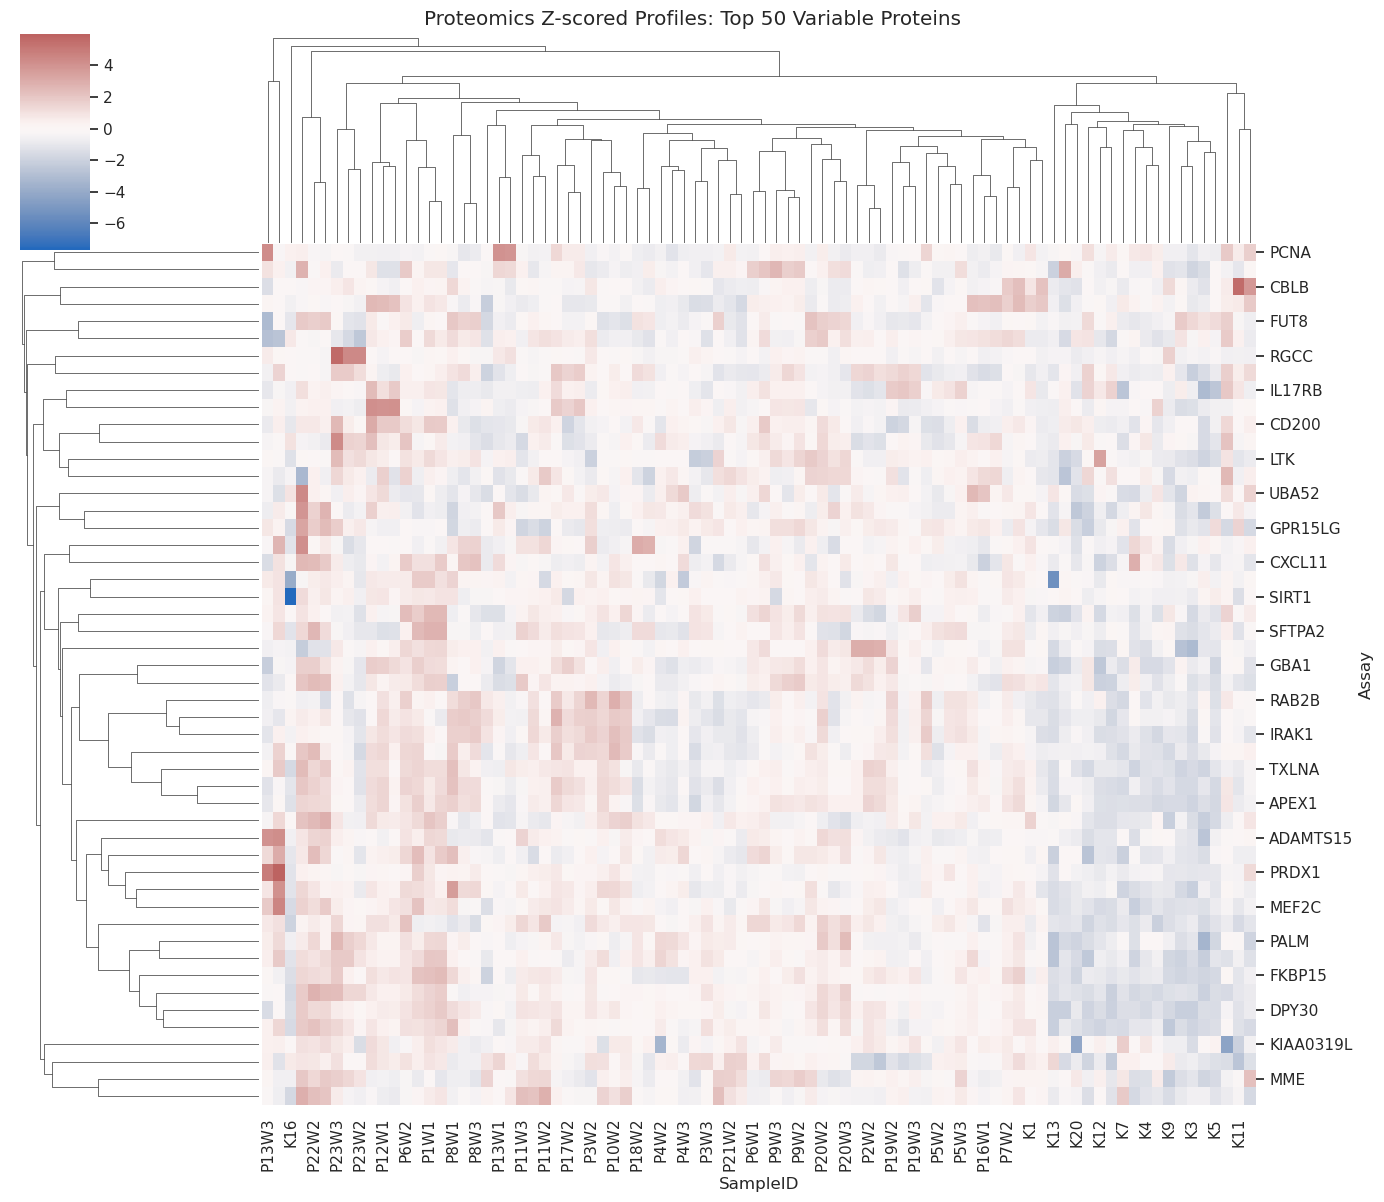

In [ ]:
heatmap_df = olink_pass.pivot(index='Assay', columns='SampleID', values='PCNormalizedNPX')

heatmap_z = pd.DataFrame(
    zscore(heatmap_df.values, axis=1, nan_policy='omit'),
    index=heatmap_df.index,
    columns=heatmap_df.columns
)

top_var = heatmap_z.var(axis=1).sort_values(ascending=False).head(50).index
heatmap_top = heatmap_z.loc[top_var]
sns.set(style="white")
g = sns.clustermap(
    heatmap_top,
    cmap='vlag',
    row_cluster=True,
    col_cluster=True,
    center=0,
    figsize=(14,12)
)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("Proteomics Z-scored Profiles: Top 50 Variable Proteins", y=1.00)
plt.show()

###### This part is about doing analyses corrected by age and gender: WARNING! ONLY FOR TREATMENTS AGE AND GENDER WAS PROVIDED, NO INFORMATION ABOUT CONTROLS

In [115]:
df_metadata = pd.read_excel('/mnt/dysk_D/Olink_Gdansk/hf_flozins_database.xlsx', header=2)

df_metadata = df_metadata.iloc[:, 1:5]

df_metadata = df_metadata.drop(df_metadata.columns[1], axis=1)

df_metadata.head()

,OLINK number,Age,Gender
0,P1,73.0,F
1,P2,67.0,M
2,P3,76.0,F
3,P4,67.0,F
4,P5,84.0,M


In [116]:
olink_pass['OLINK_tmp'] = (
    olink_pass["SampleID"]
    .str.extract(r"^(P\d+)", expand=False)
)

olink_pass = olink_pass.merge(
    df_metadata,
    how="left",
    left_on="OLINK_tmp",
    right_on="OLINK number"
)


olink_pass = olink_pass.drop(columns=["OLINK_tmp", "OLINK number"])

olink_pass["Age"] = olink_pass["Age"].astype('Int64')

###### Let's check the statistical data of 'age' column:

In [118]:
olink_pass['Age'].describe()

count      67080.0
mean     72.153846
std       5.962054
min           60.0
25%           68.0
50%           72.0
75%           76.0
max           84.0
Name: Age, dtype: Float64

###### Now we will do age and gender corrected differential analysis:

In [156]:
df = olink_pass.copy()

df['Age_treat'] = df['Age'].where(df['Group_simple'] == 'Treatment', 0)
df['Gender_treat'] = df['Gender'].where(df['Group_simple'] == 'Treatment', 'baseline')


###### First analysis: Control vs Treatment (age and gender corrected in Treatment), from smf.ols method:

In [157]:
results = []

for assay, sub in df.groupby('Assay'):
    if sub['Group_simple'].nunique() < 2:
        continue

    try:
        model = smf.ols('NPX ~ C(Group_simple) + Age_treat + C(Gender_treat)', data=sub).fit()
        coef = model.params
        pvals = model.pvalues

        
        if 'C(Group_simple)[T.Treatment]' in coef:
            results.append({
                'Assay': assay,
                'lfc': coef['C(Group_simple)[T.Treatment]'],
                'pvalue': pvals['C(Group_simple)[T.Treatment]']
            })
    except Exception as e:
        print(f"Skipping {assay} due to error: {e}")


deg_treatment = pd.DataFrame(results)


deg_treatment['fdr'] = multipletests(deg_treatment['pvalue'], method='fdr_bh')[1]

deg_treatment = deg_treatment.sort_values('fdr')

deg_treatment.head()

,Assay,lfc,pvalue,fdr
140,CCER2,-5.192146,1.124888e-10,1.160884e-07
831,RYK,-4.345773,7.200552e-10,3.715485e-07
666,NEFL,-2.872658,6.335020e-09,2.179247e-06
116,CA9,-4.107309,1.250434e-07,3.226120e-05
544,KIFAP3,3.789265,1.723295e-07,3.556881e-05


###### Adding modified vulcano-plot:

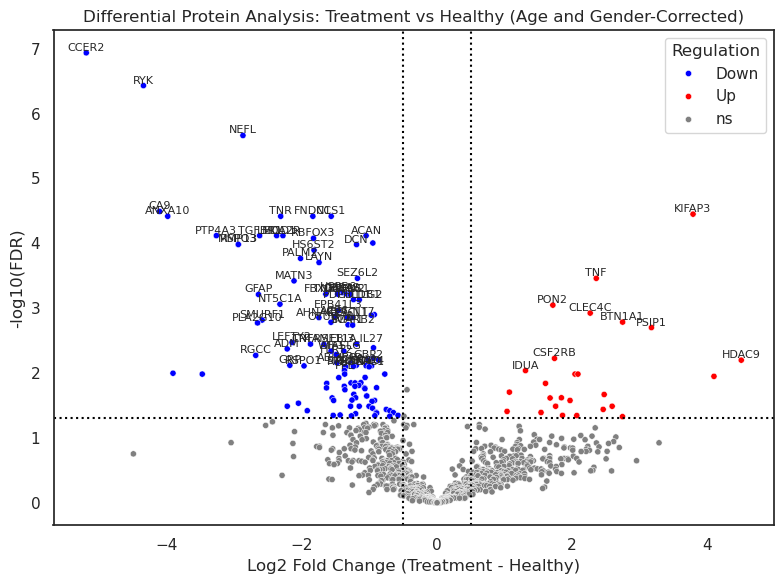

In [ ]:
def regulation_color(row):
    if row['fdr'] >= 0.05 or abs(row['lfc']) <= 0.5:
        return 'ns'
    elif row['lfc'] > 0.5:
        return 'Up'
    elif row['lfc'] < -0.5:
        return 'Down'
    else:
        return 'ns'

deg_treatment['Regulation'] = deg_treatment.apply(regulation_color, axis=1)

palette = {'Up': 'red', 'Down': 'blue', 'ns': 'grey'}


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=deg_treatment,
    x='lfc',
    y=-np.log10(deg_treatment['fdr']),
    hue='Regulation',
    palette=palette,
    s=20,      
    alpha=1
)


for _, row in deg_treatment[(deg_treatment['fdr'] < 0.01) & (abs(deg_treatment['lfc']) > 1)].iterrows():
    plt.text(row['lfc'], -np.log10(row['fdr']), row['Assay'],
             fontsize=8, ha='center', va='bottom')


plt.axhline(-np.log10(0.05), linestyle='dotted', color='black')
plt.axvline(0.5, linestyle='dotted', color='black')
plt.axvline(-0.5, linestyle='dotted', color='black')

plt.title("Differential Protein Analysis: Treatment vs Healthy (Age and Gender-Corrected)")
plt.xlabel("Log2 Fold Change (Treatment - Healthy)")
plt.ylabel("-log10(FDR)")
plt.legend(title='Regulation')
plt.tight_layout()
plt.show()

###### And up/down-regulated proteins:

In [ ]:
reg_summary_all = pd.DataFrame({
    "Dataset": [
        "FDR < 0.05",
        "FDR < 0.05 & |LFC| > 0.5",
        "FDR < 0.05 Age-corrected, ols",
        "FDR < 0.05 & |LFC| > 0.5 Age-corrected, ols"
    ],
    "Up": [
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] > 0)).sum(),
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] > 0.5)).sum(),
        ((deg_treatment['fdr'] < 0.05) & (deg_treatment['lfc'] > 0)).sum(),
        ((deg_treatment['fdr'] < 0.05) & (deg_treatment['lfc'] > 0.5)).sum()
    ],
    "Down": [
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] < 0)).sum(),
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] < -0.5)).sum(),
        ((deg_treatment['fdr'] < 0.05) & (deg_treatment['lfc'] < 0)).sum(),
        ((deg_treatment['fdr'] < 0.05) & (deg_treatment['lfc'] < -0.5)).sum()
    ]
})

print("Summary of Up- and Down-regulated Proteins")
display(reg_summary_all)


Summary of Up- and Down-regulated Proteins


,Dataset,Up,Down
0,FDR < 0.05,638,31
1,FDR < 0.05 & |LFC| > 0.5,408,16
2,"FDR < 0.05 Age-corrected, ols",26,117
3,"FDR < 0.05 & |LFC| > 0.5 Age-corrected, ols",26,115


###### On this plot we should see the differences between lfc before and after age and gender correction:

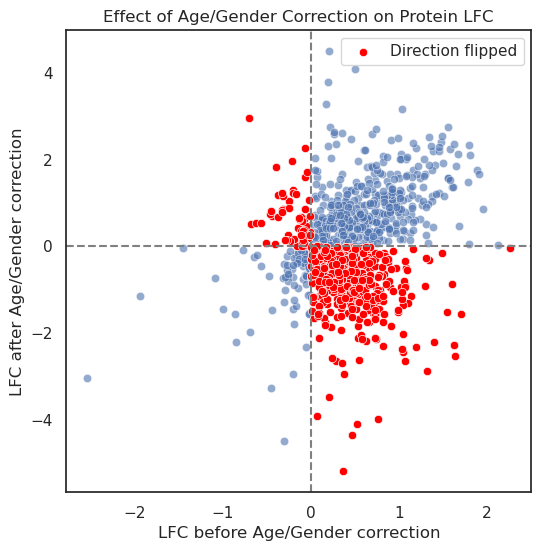

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=diff_results['lfc'],
    y=deg_treatment['lfc'],
    alpha=0.6
)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('LFC before Age/Gender correction')
plt.ylabel('LFC after Age/Gender correction')
plt.title('Effect of Age/Gender Correction on Protein LFC')


flip_idx = (diff_results['lfc'] * deg_treatment['lfc']) < 0
sns.scatterplot(
    x=diff_results.loc[flip_idx, 'lfc'],
    y=deg_treatment.loc[flip_idx, 'lfc'],
    color='red',
    label='Direction flipped'
)

plt.legend()
plt.show()

###### In this part final we will save important (after corrections and with logfc and fdr thresholds) up- and down-regulated genes to a csv list

In [ ]:
threshold_fdr = 0.05
threshold_lfc = 0.5



threshold_fdr = 0.05
threshold_lfc = 0.5


deg_treatment['regulation'] = np.where(
    (deg_treatment['fdr'] < threshold_fdr) & (deg_treatment['lfc'] > threshold_lfc), 'Up',
    np.where(
        (deg_treatment['fdr'] < threshold_fdr) & (deg_treatment['lfc'] < -threshold_lfc),
        'Down',
        None  
    )
)


genes_filtered = deg_treatment.dropna(subset=['regulation'])


genes_table = genes_filtered[['Assay', 'regulation']].rename(columns={'Assay': 'gene'})


print(genes_table)

genes_table.to_csv('up_down_genes_age_corrected.csv', index=False)

       gene regulation
140   CCER2       Down
831     RYK       Down
666    NEFL       Down
116     CA9       Down
544  KIFAP3         Up
..      ...        ...
134    CAST         Up
203    CFC1       Down
927   TAFA5       Down
205  CHCHD6       Down
326    EML4         Up

[141 rows x 2 columns]


###### Now we will do paired-analysis of treatment specific and control (before_treatment, treatment_1, treatment_3):

In [ ]:
pairwise_groups = [
    ("control", "be_treatment"),
    ("control", "treatment_1"),
    ("control", "treatment_3")
]

results_list = []

for g1, g2 in pairwise_groups:
    print(f"Analyzing {g1} vs {g2}")
    
    
    sub = olink_pass[olink_pass['Group_Name1'].isin([g1, g2])].copy()

    
    sub['Group_Name1'] = pd.Categorical(sub['Group_Name1'], categories=[g1, g2])

    for assay in sub['Assay'].unique():
        f = sub[sub['Assay'] == assay]
        if f['Group_Name1'].nunique() < 2:
            continue  

        # linear model only vs group
        model = smf.ols("NPX ~ C(Group_Name1)", data=f).fit()

        
        term_name = f"C(Group_Name1)[T.{g2}]"
        if term_name in model.params.index:
            estimate = model.params[term_name]
            pval = model.pvalues[term_name]
            results_list.append({
                'Assay': assay,
                'Comparison': f"{g1} vs {g2}",
                'lfc': estimate,
                'pvalue': pval
            })


pairwise_results = pd.DataFrame(results_list)
pairwise_results['fdr'] = multipletests(pairwise_results['pvalue'], method='fdr_bh')[1]
pairwise_results = pairwise_results.sort_values(['Comparison', 'fdr'])
pairwise_results.head(10)

Analyzing control vs be_treatment
Analyzing control vs treatment_1
Analyzing control vs treatment_3


,Assay,Comparison,lfc,pvalue,fdr
314,EDA2R,control vs be_treatment,1.528442,4.084394e-13,4.215094e-10
301,DPY30,control vs be_treatment,0.985980,4.408148e-12,1.240693e-09
184,CDCP1,control vs be_treatment,1.426252,1.161484e-11,1.854019e-09
956,TNFRSF10B,control vs be_treatment,0.940917,1.138201e-11,1.854019e-09
459,IFI30,control vs be_treatment,1.445148,3.650599e-11,4.943767e-09
841,SCARB2,control vs be_treatment,0.668037,8.786800e-11,9.067978e-09
666,NEFL,control vs be_treatment,1.244572,2.703226e-10,1.992663e-08
28,AFAP1L1,control vs be_treatment,1.114712,5.387606e-10,3.571920e-08
428,HAVCR1,control vs be_treatment,1.462476,6.780066e-10,3.840294e-08
732,PHLDB1,control vs be_treatment,0.689920,6.822227e-10,3.840294e-08


###### For every comparison we plot vulcanoplot:

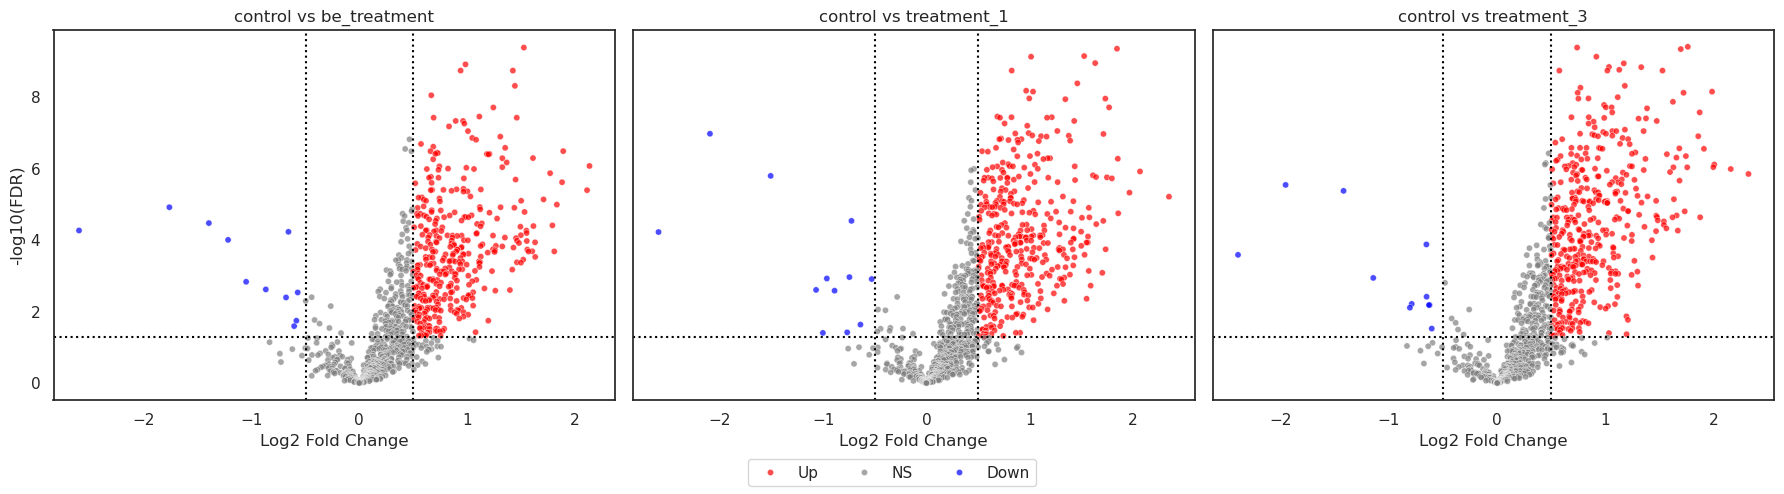

In [168]:
threshold_fdr = 0.05
threshold_lfc = 0.5


comparisons = pairwise_results['Comparison'].unique()


fig, axes = plt.subplots(1, len(comparisons), figsize=(18, 5), sharey=True)

for ax, comp in zip(axes, comparisons):
    df = pairwise_results[pairwise_results['Comparison'] == comp].copy()
    
    
    df['regulation'] = np.where(
        (df['fdr'] < threshold_fdr) & (df['lfc'] > threshold_lfc), 'Up',
        np.where((df['fdr'] < threshold_fdr) & (df['lfc'] < -threshold_lfc), 'Down', 'NS')
    )
    
   
    sns.scatterplot(
        data=df,
        x='lfc',
        y=-np.log10(df['fdr']),
        hue='regulation',
        palette={'Up':'red', 'Down':'blue', 'NS':'grey'},
        ax=ax,
        s=20,
        alpha=0.7
    )
    
   
    ax.axhline(-np.log10(threshold_fdr), linestyle='dotted', color='black')
    ax.axvline(threshold_lfc, linestyle='dotted', color='black')
    ax.axvline(-threshold_lfc, linestyle='dotted', color='black')
    
    ax.set_title(comp)
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-log10(FDR)' if ax==axes[0] else '')
    ax.legend_.remove()  


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

###### And now numbers of genes that are up- or downregulated:

In [169]:
threshold_fdr = 0.05
threshold_lfc = 0.5

summary_list = []

for comp in pairwise_results['Comparison'].unique():
    df = pairwise_results[pairwise_results['Comparison'] == comp].copy()
    
    
    df['regulation'] = np.where(
        (df['fdr'] < threshold_fdr) & (df['lfc'] > threshold_lfc), 'Up',
        np.where((df['fdr'] < threshold_fdr) & (df['lfc'] < -threshold_lfc), 'Down', 'NS')
    )
    
    up_count = (df['regulation'] == 'Up').sum()
    down_count = (df['regulation'] == 'Down').sum()
    
    summary_list.append({
        'Comparison': comp,
        'Up-regulated': up_count,
        'Down-regulated': down_count
    })

summary_df = pd.DataFrame(summary_list)
summary_df

,Comparison,Up-regulated,Down-regulated
0,control vs be_treatment,363,11
1,control vs treatment_1,395,12
2,control vs treatment_3,424,11
